# Predicting Service Request Loads

## 05.01. Loading Time Series Data

The data represents hourly total service requests for 5 weeks, starting with monday.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the sequence data from CSV
requests = pd.read_csv('requests_every_hour.csv',header=0)

#Review loaded data
print(requests.dtypes)
requests.head()

Requests    int64
dtype: object


,Requests
0,100
1,113
2,162
3,186
4,228


In [4]:
requests.shape
#we have 35 days data

(840, 1)

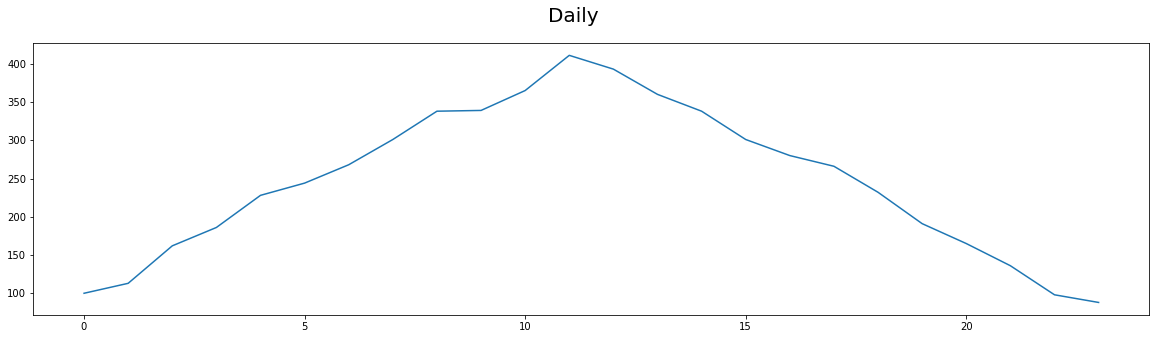

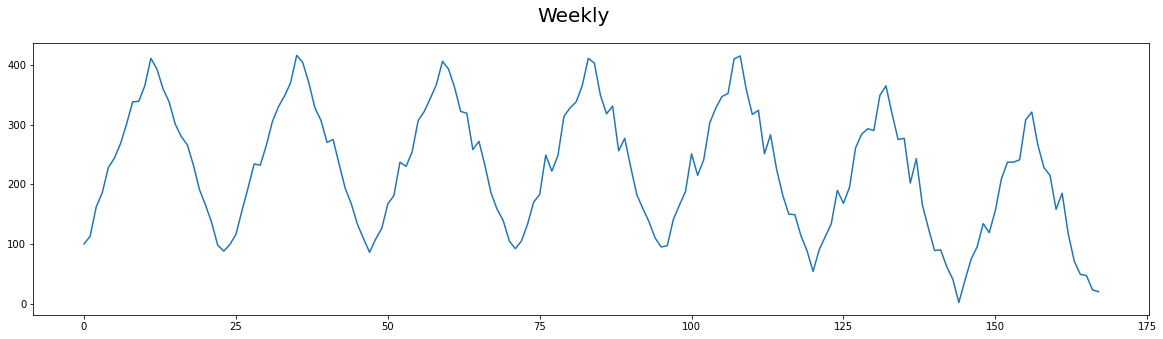

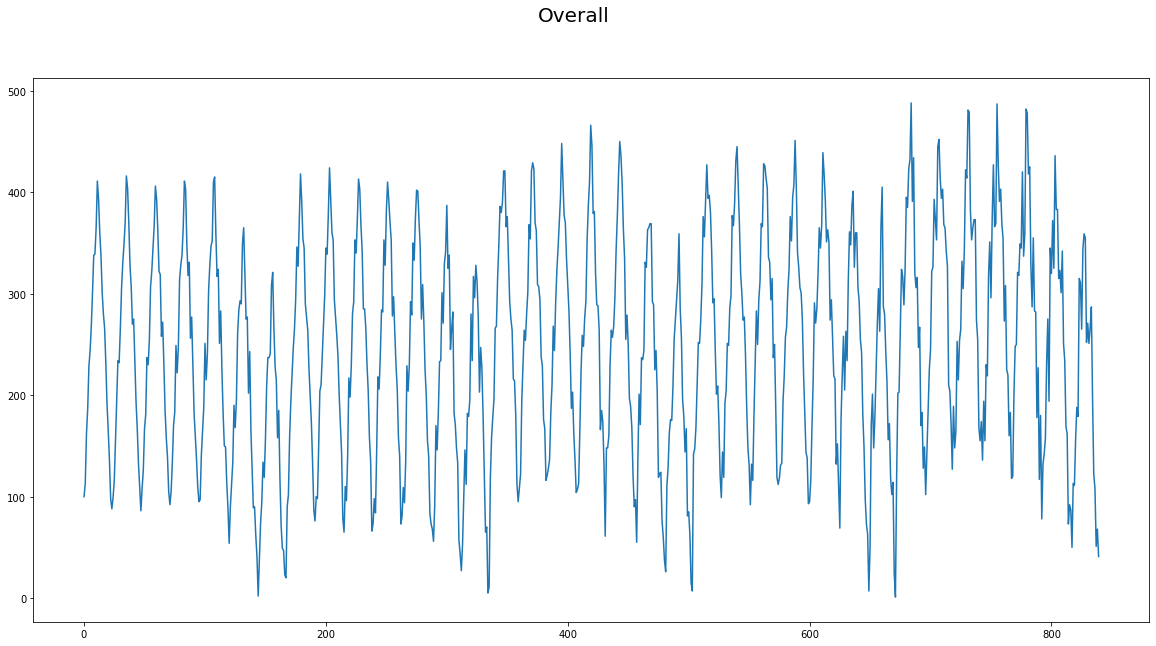

In [6]:
#Plat the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168))
plt.show()

#all
plt.figure(figsize=(20,10)).suptitle("Overall", fontsize=20)
plt.plot(requests)
plt.show()

## Preparing Time Series Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

#Scale the data
print("Request Range before scaling : " , 
          min(requests.Requests),
          max(requests.Requests))

scaler = MinMaxScaler()
scaled_requests=scaler.fit_transform(requests)
print("Request Range after scaling : " , 
          min(scaled_requests),
          max(scaled_requests))

#Training data has to be sequencial - first 4 weeks
train_size = 24 * 7 * 4

#Number of samples to lookback for each sample
lookback=24 * 7

#Separate training and test data
train_requests = scaled_requests[0:train_size,:]

#Add an additional week for lookback.
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train, Test : ",
      train_requests.shape, test_requests.shape)

Request Range before scaling :  1 488
Request Range after scaling :  [0.] [1.]

 Shaped of Train, Test :  (672, 1) (336, 1)


## Prepare RNN Dataset. 

In [9]:

#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (503, 1, 168) (503,)


## Build a LSTM model with Keras

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
ts_model=Sequential()
#Add LSTM
ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
ts_model.summary()

#Train the model
ts_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               435200    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 435,457
Trainable params: 435,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0141 - mse: 0.0141
Epoch 2/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 3/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0048 - mse: 0.0048
Epoch 4/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 5/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0043 - mse: 0.0043


## Testing

In [21]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
ts_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict for the training dataset
predict_on_train= ts_model.predict(train_req_x)
#Predict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.0132 - mse: 0.0132


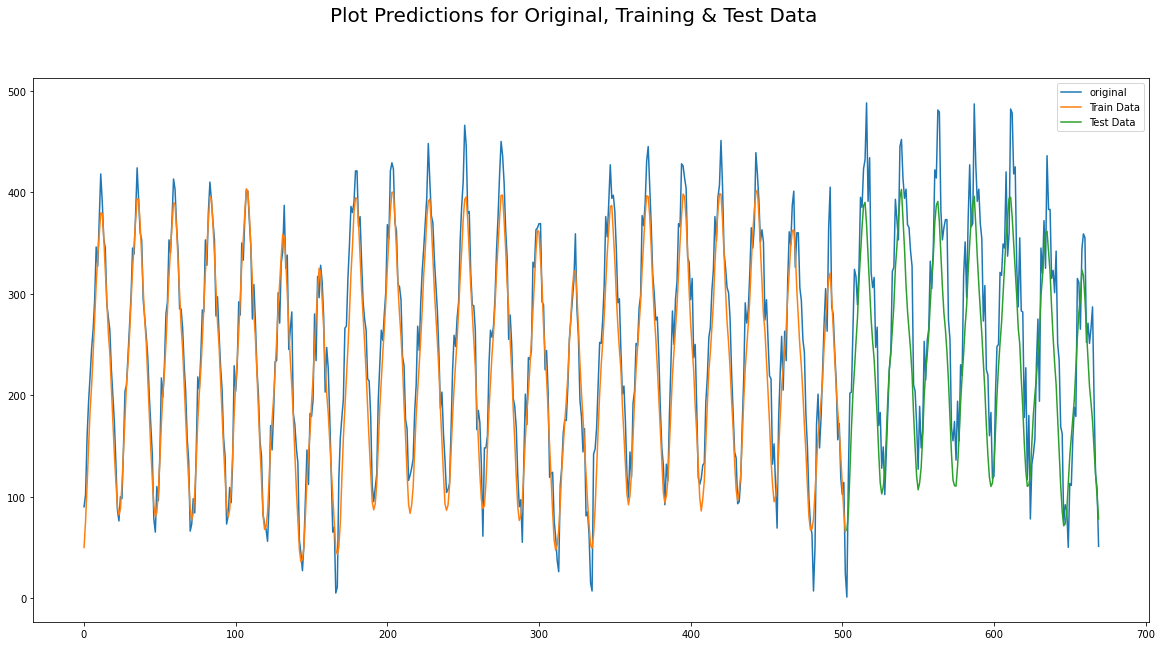

In [27]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train) + len(predict_on_test)

#Plot original data
orig_data=requests.Requests.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

#Create a plot for original data
orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

#Create a plot for predictions on training
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Create a plot for predictions on testing
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test

#Plot the graphs
plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data", fontsize=20)
plt.plot(orig_plot,label="original")
plt.plot(predict_train_plot,label="Train Data")
plt.plot(predict_test_plot,label="Test Data")
plt.legend()
plt.show()

In [28]:
#Use last part of the training data as the initial lookback
curr_input= test_req_x[-1,:].flatten()

#Predict for the next week
predict_for = 24 * 7

for i in range(predict_for):
    
    #Take the last lookback no. of samples as X
    this_input=curr_input[-lookback:]
    #Create the input
    this_input=this_input.reshape((1,1,lookback))
    #Predict for the next point
    this_prediction=ts_model.predict(this_input)

    #Add the current prediction to the input
    curr_input = np.append(curr_input,this_prediction.flatten())

#Extract the last predict_for part of curr_input, which contains all the new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# #Inverse to view results
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

[[ 78.04995814]
 [ 79.72095302]
 [ 91.03677933]
 [113.11418885]
 [138.89408743]]


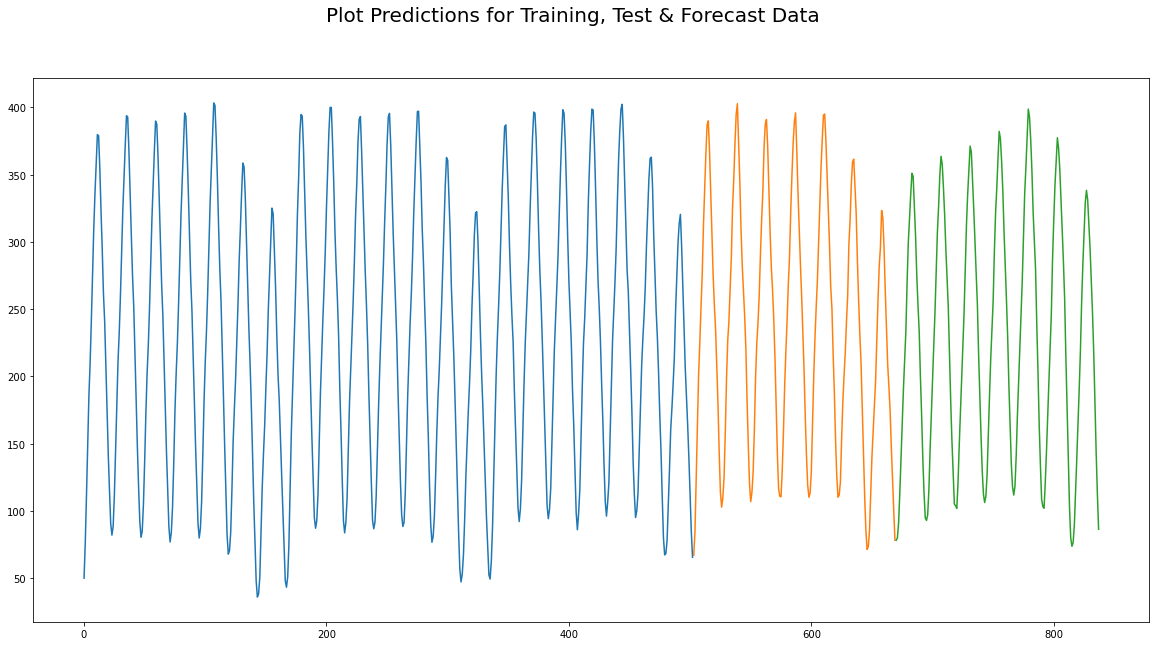

In [29]:
#Plot the training data with the forecast data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

#Setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Setup test chart
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

#Setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data", fontsize=20)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.plot(predict_future_plot)
plt.show()